In [1]:
import numpy as np
import matplotlib.pyplot as plt
from brian2 import *
%matplotlib inline
plt.viridis()

In [111]:
# Membrane
v_rest = -70 * mvolt #mV
e_ext = 0 * mvolt #V
v_thr = -54 * mvolt #mV
g_max = 0.2
tau_m = 20* ms #ms
tau_ex = 5* ms #ms
e = np.e
g = g_max
pre_t = 0 * ms
rate = 200 * Hz


WARNING    "presynaptic_spike" is an internal variable of group "neurongroup", but also exists in the run namespace with the value 0. * second. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


rate =  0. Hz


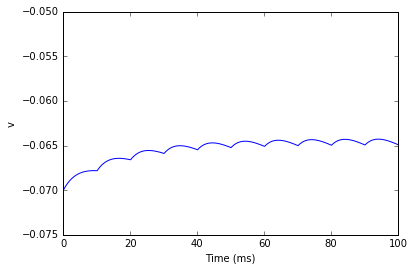

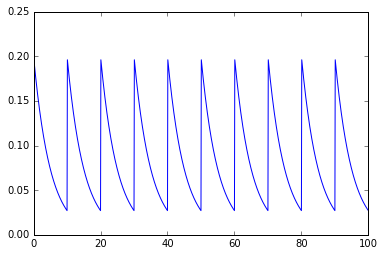

In [139]:
start_scope()
# Membrane
# v_rest = -70 * mvolt #mV
# e_ext = 0 * mvolt #V
# v_thr = -54 * mvolt #mV
# g_max = 0.2
# tau_m = 20* ms #ms
# tau_ex = 5* ms #ms
presynaptic_spike = 0 * ms
eqs = '''
dv/dt = (v_rest-v + gex * (e_ext - v))/tau_m : volt
# g : 1 (linked)
gex = g * e ** (-(t-presynaptic_spike)/tau_ex): 1
presynaptic_spike : second

'''
G = NeuronGroup(1, eqs, threshold='v > -54 * mV',
                reset='v = -70 * mV', method = 'euler', dt=0.1 * ms)#, events={'trigger_stdp' : 'v > v_thr'})
G.v = -70*mV
# G.run_on_event('trigger_stdp', 'x=0')
# event_mon = EventMonitor(group, 'trigger_stdp')
statemon = StateMonitor(G, ['v', 'gex',], record=0)
spikemon = SpikeMonitor(G)


# Pre pop
times = np.arange(rate  * (100 *ms)) * 10 * ms
inp = SpikeGeneratorGroup(1, [0] * len(times), times)

# Connection from pre pop
synapse_model = '''
# dg/dt = 0 :1
'''
feedforward = Synapses(inp, G, model=synapse_model, on_pre='presynaptic_spike_post = t_post')
feedforward.connect(j='i')
# feedforward.g = g_max



# G.g = linked_var(feedforward, 'g')
# print G.g



run(100*ms)

plot(statemon.t/ms, statemon.v[0])
for t in spikemon.t:
    axvline(t/ms, ls='--', c='r', lw=3)
    print t,
xlabel('Time (ms)')
ylabel('v')
ylim([-.075, -.05])
figure()
plot(statemon.t/ms, statemon.gex[0])
print "rate = ", len(spikemon.t) / (100 * ms)

In [100]:
np.arange(rate  * (100 *ms)) * 10 * ms

array([   0.,   10.,   20.,   30.,   40.,   50.,   60.,   70.,   80.,
         90.,  100.,  110.,  120.,  130.,  140.,  150.,  160.,  170.,
        180.,  190.]) * msecond

In [110]:
print times

[   0.   10.   20.   30.   40.   50.   60.   70.   80.   90.  100.  110.
  120.  130.  140.  150.  160.  170.  180.  190.] ms
